In [21]:
from astropy.io import fits
from pygsm import GSMObserver
import numpy as np
from scipy import interpolate
from datetime import datetime
from astropy.time import Time
import matplotlib.pyplot as plt
import healpy as hp
import time

In [48]:
hera_beam_file = '/Users/tyler/Desktop/Research/Tsys/data/HERA_beam_nic.hmap'

df = 1.5625  # 100 MHz / 64 averaged channels
freqs = np.arange(100.0 + df / 2.0, 200.0, df)
hours = np.arange(0.0, 24.0, .5)
lsts = np.zeros_like(hours)
pols = ['X', 'Y']  # Only have X beam, but try rotating 90 degrees for Y
HERA_Tsky = np.zeros((len(pols), freqs.shape[0], lsts.shape[0]))

In [23]:
# Read in HERA beam data, just use full sky for paper
hera_beam = {}
# Only have X right now, will rotate later
hera_im = fits.getdata(hera_beam_file, extname='BEAM_{0}'.format('X'))
nside = hp.npix2nside(hera_im.shape[0])
temp_f = fits.getdata(hera_beam_file, extname='FREQS_{0}'.format('X'))
# Interpolate to the desired frequencies
func = interpolate.interp1d(temp_f, hera_im, kind='cubic', axis=1)

for pol in pols:
    hera_beam[pol] = func(freqs)

In [24]:
# Set up the observer
(latitude, longitude, elevation) = ('-30.7224', '21.4278', 1100)
ov = GSMObserver()
ov.lon = longitude
ov.lat = latitude
ov.elev = elevation

In [25]:
proj_sky = hp.projector.OrthographicProj(rot=[0,0,0], half_sky=True, xsize=400)
f = lambda x,y,z: hp.pixelfunc.vec2pix(nside,x,y,z,nest=False)

In [32]:
vals = []

for poli, pol in enumerate(pols[:1]):
    pol_ang = 90 * (1 - poli)  # Extra rotation for X
    proj_beam = hp.projector.OrthographicProj(rot=[pol_ang,90], half_sky=True, xsize=400)
    for fi, freq in enumerate(freqs[:1]):
        
        print 'Forming HERA Tsky for frequency ' + str(freq) + ' MHz.'
    
        #deg = 8

        #smoothed_beam = hp.sphtfunc.smoothing(hera_beam[pol][:, fi], fwhm=0.017*deg)
        hbeam1 = proj_beam.projmap(hera_beam[pol][:, fi], f)
        hbeam1[np.isinf(hbeam1)] = np.nan

        for ti, t in enumerate(hours[:]):
            dt = datetime(2013, 1, 1, np.int(t), np.int(60.0 * (t - np.floor(t))),
                          np.int(60.0 * (60.0 * t - np.floor(t * 60.0))))
            lsts[ti] = Time(dt).sidereal_time('apparent', longitude).hour
            ov.date = dt
            observed_sky = ov.generate(freq)
            nside_sky = hp.pixelfunc.npix2nside(hp.pixelfunc.get_map_size(observed_sky))
            f_sky = lambda x,y,z: hp.pixelfunc.vec2pix(nside_sky,x,y,z, nest=False)
            sky = proj_sky.projmap(observed_sky, f_sky)
            sky[np.isinf(sky)] = np.nan
            HERA_Tsky[poli, fi, ti] = np.nanmean(hbeam1 * sky) / np.nanmean(hbeam1)
            vals.append(np.nanmean(hbeam1 * sky) / np.nanmean(hbeam1))

Forming HERA Tsky for frequency 100.78125 MHz.


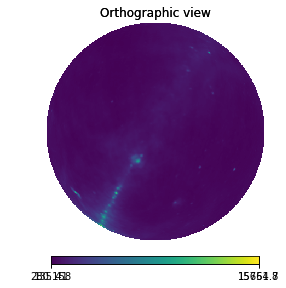

In [33]:
vals_org = []

fig = plt.figure("Tsky calc")

for poli, pol in enumerate(pols[:1]):
    pol_ang = 90 * (1 - poli)  # Extra rotation for X
    for fi, freq in enumerate(freqs[:1]):
        # Rotate and project hera beam (Need to figure out how to do this w/o making figure)
        pol_ang = 90 * (1 - poli)  # Extra rotation for X
        hbeam = hp.orthview(hera_beam[pol][:, fi], rot=[pol_ang, 90], fig=fig.number,
                            xsize=400, return_projected_map=True, half_sky=True)
        hbeam[np.isinf(hbeam)] = np.nan

        for ti, t in enumerate(hours[:]):
            plt.clf()
            dt = datetime(2013, 1, 1, np.int(t), np.int(60.0 * (t - np.floor(t))),
                          np.int(60.0 * (60.0 * t - np.floor(t * 60.0))))
            lsts[ti] = Time(dt).sidereal_time('apparent', longitude).hour
            ov.date = dt
            ov.generate(freq)
            d = ov.view(fig=fig.number)
            sky = hp.orthview(d, fig=fig.number, xsize=400, return_projected_map=True,
                              half_sky=True)
            sky[np.isinf(sky)] = np.nan
            HERA_Tsky[poli, fi, ti] = np.nanmean(hbeam * sky) / np.nanmean(hbeam)
            vals_org.append(np.nanmean(hbeam * sky) / np.nanmean(hbeam))

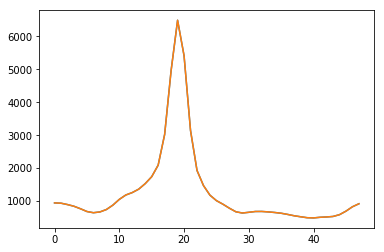

In [35]:
plt.plot(vals)
plt.plot(vals_org)

In [52]:
hera_beam_file = '/Users/tyler/Desktop/Research/Tsys/data/HERA_beam_nic.hmap'

df = 1.5625  # 100 MHz / 64 averaged channels
freqs = np.arange(100.0 + df / 2.0, 200.0, df)
hours = np.arange(0.0, 24.0, .5)
lsts = np.zeros_like(hours)
pols = ['X', 'Y']  # Only have X beam, but try rotating 90 degrees for Y
HERA_Tsky = np.zeros((len(pols), freqs.shape[0], lsts.shape[0]))

# Set up the observer
(latitude, longitude, elevation) = ('-30.7224', '21.4278', 1100)
ov = GSMObserver()
ov.lon = longitude
ov.lat = latitude
ov.elev = elevation

proj_sky = hp.projector.OrthographicProj(rot=[0,0,0], half_sky=True, xsize=400)

observed_sky = ov.generate(100)

nside_sky = hp.pixelfunc.npix2nside(hp.pixelfunc.get_map_size(observed_sky))
f_sky = lambda x,y,z: hp.pixelfunc.vec2pix(nside_sky, x, y, z, nest=False)
sky = proj_sky.projmap(observed_sky, f_sky)

generated_sky = np.zeros((1, hours.shape[0], sky.shape[0],
                          sky.shape[1]))


for fi, freq in enumerate(freqs[10:11]):
    print 'Forming Tsky for frequency ' + str(freq) + ' MHz.'
    for ti, t in enumerate(hours[:]):
        dt = datetime(2013, 1, 1, np.int(t), np.int(60.0 * (t - np.floor(t))),
                      np.int(60.0 * (60.0 * t - np.floor(t * 60.0))))
        lsts[ti] = Time(dt).sidereal_time('apparent', longitude).hour
        ov.date = dt
        observed_sky = ov.generate(freq)
        sky = proj_sky.projmap(observed_sky, f_sky)
        sky[np.isinf(sky)] = np.nan
        sky = np.flip(sky, axis=0)
        generated_sky[fi, ti, :, :] = sky

        

Forming Tsky for frequency 116.40625 MHz.


Forming Tsky for frequency 116.40625 MHz.


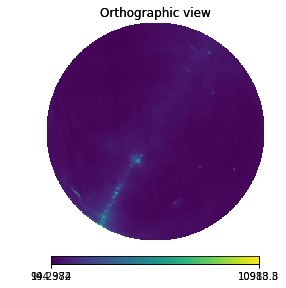

In [53]:
g_sky = np.zeros((1, hours.shape[0], sky.shape[0],
                          sky.shape[1]))

fig = plt.figure("Tsky calc")

for fi, freq in enumerate(freqs[10:11]):
    print 'Forming Tsky for frequency ' + str(freq) + ' MHz.'
    for ti, t in enumerate(hours[:]):
        plt.clf()
        dt = datetime(2013, 1, 1, np.int(t), np.int(60.0 * (t - np.floor(t))),
                      np.int(60.0 * (60.0 * t - np.floor(t * 60.0))))
        lsts[ti] = Time(dt).sidereal_time('apparent', longitude).hour
        ov.date = dt
        ov.generate(freq)
        d = ov.view(fig=fig.number)
        sky = hp.orthview(d, fig=fig.number, xsize=400, return_projected_map=True,
                          half_sky=True)
        sky[np.isinf(sky)] = np.nan
        g_sky[fi,ti,:,:] = sky

In [51]:
for i in np.arange(generated_sky.shape[1]):
    print np.nanmean(generated_sky[0,i,:,:]-g_sky[0,i,:,:])

1.3506338346059807e-14
-3.2601506352558156e-15
-9.314716100730902e-15
4.005327923314288e-14
-4.2381958258325604e-14
2.095811122664453e-14
-3.1670034742485066e-14
5.612116450690369e-14
6.986037075548176e-15
-2.817701620471098e-14
5.821697562956814e-14
6.753169173029904e-15
4.377916567343524e-14
-4.8087221870023284e-14
3.312545913322427e-14
-1.0187970735174425e-15
-6.462084294882063e-15
-2.095811122664453e-15
-7.21890497806645e-15
8.616112393176085e-15
-2.8409884107229252e-14
1.9560903811534893e-14
6.520301270511631e-15
-1.1177659320877082e-14
-5.588829660438541e-15
0.0
1.8629432201461803e-15
-1.0246187710803992e-14
-6.054565465475086e-15
-1.723222478635217e-14
1.1410527223395355e-14
-2.3286790251827254e-15
0.0
-9.314716100730902e-16
-2.7944148302192705e-15
2.7944148302192705e-15
9.314716100730902e-16
9.314716100730902e-16
9.314716100730902e-16
-1.3972074151096352e-15
-1.1643395125913627e-15
2.3286790251827254e-16
0.0
-2.7944148302192705e-15
-1.8629432201461803e-15
-6.520301270511631e-15